<a href="https://colab.research.google.com/github/anuragal/deep-learning/blob/master/S9/S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model

In [1]:
!pip install albumentations==0.4.5

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torchsummary
from torchsummary import summary

from models.resnet18 import ResNet18

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## Run the Model

In [0]:
%matplotlib inline

In [3]:
from dataloader import ImageData
from models.resnet18 import ResNet18
from datamodel import DataModel

# Loading data and transforming it
img_data = ImageData()

# Choose from "albumentations" or "pytorch". Default is "pytorch"
img_data.load("albumentations")

# training the dataset and then running test
dm = DataModel(img_data, num_of_epochs = 50, cal_misclassified = True)
dm.run_model(ResNet18(), device)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.373788833618164 Batch_id=390 Accuracy=40.03: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 5169/10000 (51.69%)

EPOCH: 2


Loss=0.9290573000907898 Batch_id=390 Accuracy=57.39: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 6421/10000 (64.21%)

EPOCH: 3


Loss=0.9254539608955383 Batch_id=390 Accuracy=66.60: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 7021/10000 (70.21%)

EPOCH: 4


Loss=0.8054359555244446 Batch_id=390 Accuracy=72.61: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 7611/10000 (76.11%)

EPOCH: 5


Loss=0.703390896320343 Batch_id=390 Accuracy=76.20: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 7604/10000 (76.04%)

EPOCH: 6


Loss=0.665557324886322 Batch_id=390 Accuracy=78.66: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8098/10000 (80.98%)

EPOCH: 7


Loss=0.6351624727249146 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8121/10000 (81.21%)

EPOCH: 8


Loss=0.5621917843818665 Batch_id=390 Accuracy=81.76: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8065/10000 (80.65%)

EPOCH: 9


Loss=0.4602159559726715 Batch_id=390 Accuracy=83.20: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8180/10000 (81.80%)

EPOCH: 10


Loss=0.49615544080734253 Batch_id=390 Accuracy=84.13: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8414/10000 (84.14%)

EPOCH: 11


Loss=0.26051515340805054 Batch_id=390 Accuracy=85.16: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8248/10000 (82.48%)

EPOCH: 12


Loss=0.34961000084877014 Batch_id=390 Accuracy=85.59: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8453/10000 (84.53%)

EPOCH: 13


Loss=0.5881631970405579 Batch_id=390 Accuracy=86.14: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7924/10000 (79.24%)

EPOCH: 14


Loss=0.46122869849205017 Batch_id=390 Accuracy=86.65: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8545/10000 (85.45%)

EPOCH: 15


Loss=0.4642466604709625 Batch_id=390 Accuracy=87.20: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8421/10000 (84.21%)

EPOCH: 16


Loss=0.2936382293701172 Batch_id=390 Accuracy=87.43: 100%|██████████| 391/391 [03:27<00:00,  1.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8472/10000 (84.72%)

EPOCH: 17


Loss=0.22307386994361877 Batch_id=390 Accuracy=87.72: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8676/10000 (86.76%)

EPOCH: 18


Loss=0.3840788006782532 Batch_id=390 Accuracy=88.16: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8560/10000 (85.60%)

EPOCH: 19


Loss=0.3134301006793976 Batch_id=390 Accuracy=88.65: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8416/10000 (84.16%)

EPOCH: 20


Loss=0.2793669104576111 Batch_id=390 Accuracy=88.38: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8589/10000 (85.89%)

EPOCH: 21


Loss=0.43270549178123474 Batch_id=390 Accuracy=88.78: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8502/10000 (85.02%)

EPOCH: 22


Loss=0.32057875394821167 Batch_id=390 Accuracy=88.79: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8567/10000 (85.67%)

EPOCH: 23


Loss=0.2782222032546997 Batch_id=390 Accuracy=88.80: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8675/10000 (86.75%)

EPOCH: 24


Loss=0.36765557527542114 Batch_id=390 Accuracy=89.39: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8627/10000 (86.27%)

EPOCH: 25


Loss=0.3839396834373474 Batch_id=390 Accuracy=89.32: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8670/10000 (86.70%)

EPOCH: 26


Loss=0.49325066804885864 Batch_id=390 Accuracy=89.52: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8650/10000 (86.50%)

EPOCH: 27


Loss=0.260998398065567 Batch_id=390 Accuracy=89.73: 100%|██████████| 391/391 [03:08<00:00,  2.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8640/10000 (86.40%)

EPOCH: 28


Loss=0.3415825068950653 Batch_id=390 Accuracy=89.54: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8680/10000 (86.80%)

EPOCH: 29


Loss=0.3659190237522125 Batch_id=390 Accuracy=90.03: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8660/10000 (86.60%)

EPOCH: 30


Loss=0.24475376307964325 Batch_id=390 Accuracy=89.98: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]



Test set: Average loss: 0.0035, Accuracy: 8819/10000 (88.19%)

****Required Accuracy is acheived****


## Plotting Validation Accuracy

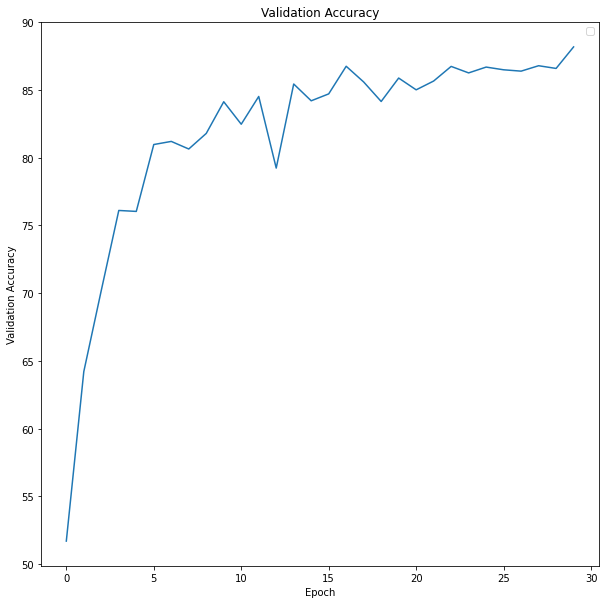

In [4]:
dm.plot_accuracy_graph()

## Plotting Loss Graph

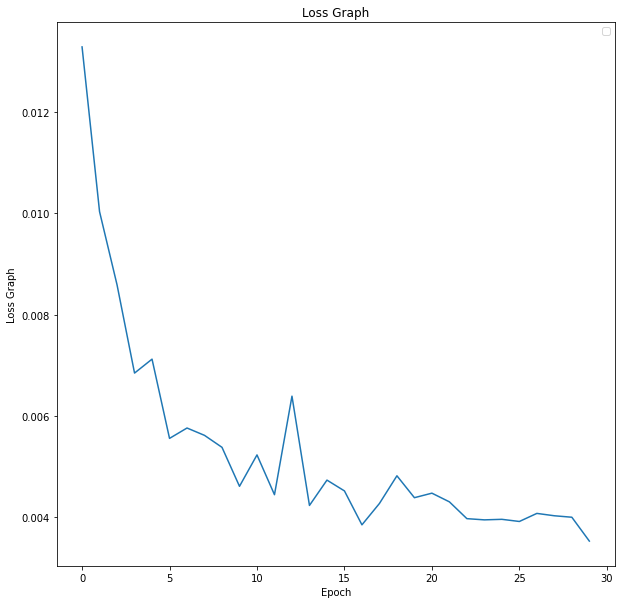

In [5]:
dm.plot_loss_graph()

## Plotting Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

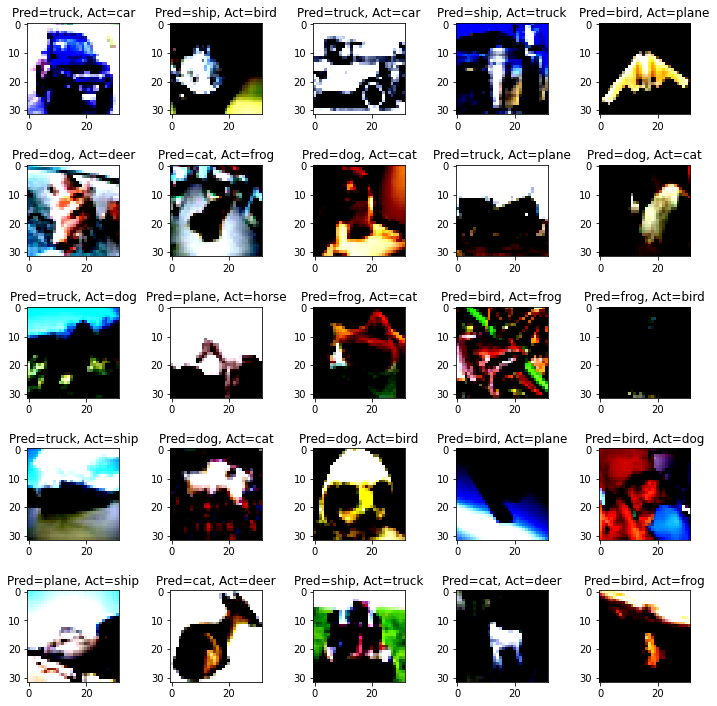

In [6]:
dm.plot_misclassified()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

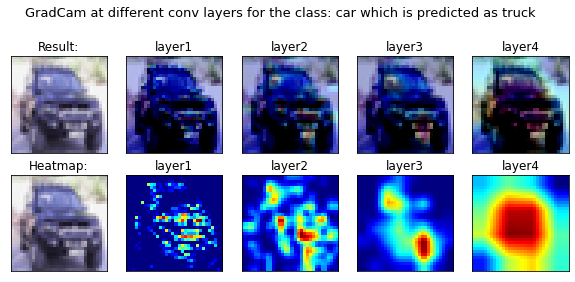

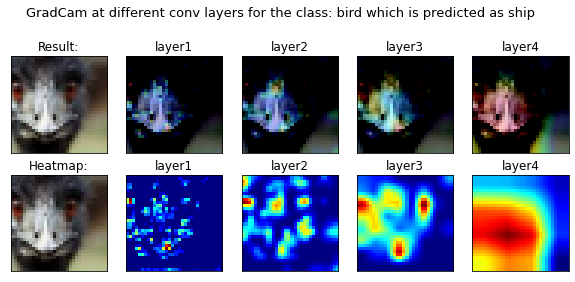

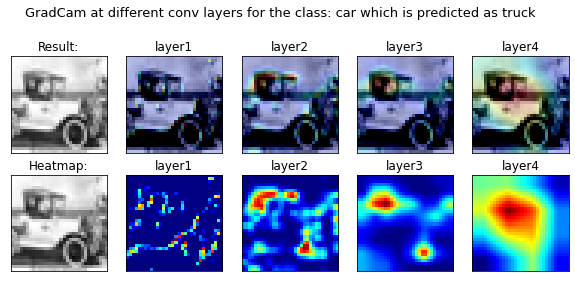

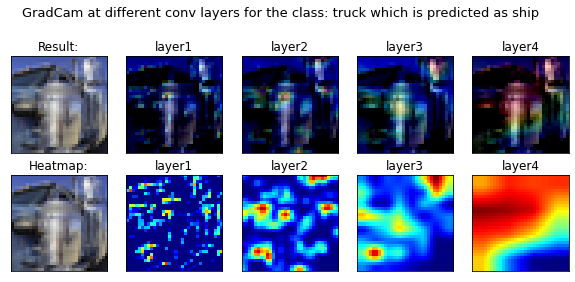

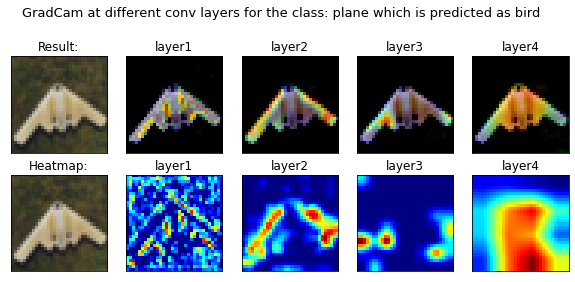

In [7]:
dm.plot_GRADcam(["layer1","layer2","layer3","layer4"])